In [1]:
from cgeniepy.ecology import EcoModel
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cgeniepy.array import GriddedData

arc_mask = xr.load_dataarray("../data/masked_array.nc")

def mask_arctic(input_data):
    "apply the new land-sea mask to the data"
    input_data = input_data * arc_mask
    return input_data

def pft_change(model):
    #carbon_thresholds = model.eco_pars()['q_C']

    ## recalculate because foram use a different method
    qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
    qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
    volume = model.eco_pars()['volume']
    carbon_thresholds = qcarbon_a * volume ** qcarbon_b

    ## counting from 0
    phyto_index = np.arange(0,32)
    zoo_index = np.arange(32,64)
    mixo_index = np.arange(64,96)
    foram_index = np.arange(96,112)

    ## diversity (no. of PFTs) map

    model_mask = model.grid_mask()

    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft> threshold, 1, 0.0)
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)

    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask
    foram_rich = xr.concat(foram_rich, dim='pft')*model_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

    total_pft = total_pft *model_mask
    total_pft = GriddedData(total_pft, attrs={'long_name': 'Total PFTs',  'units': ''})
    return total_pft

model = EcoModel("../model/muffin.u067bc.PO4Fe.main", gemflag=['biogem', 'ecogem'])
total_effect = pft_change(model)

light = model.get_var("phys_fxsw")
light_diff = light[4] - light[0]

In [2]:
chl = model.get_var("eco2D_Plankton_Chl_Total")
c = model.get_var("eco2D_Plankton_C_Total")
chl_c = chl/c
chl_c = mask_arctic(chl_c).mean(dim='lon')[1]

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
extinction = pd.read_csv("../output/trait_df.csv")['extinction']
# accumulate each PFT’s lat-mean into a list of DataFrames
dfs = []
tmp = []
for i, e in enumerate(extinction):
    if e == 0.0:
        
        pft = model.get_pft(i+1).isel(time=1)        
        pft = mask_arctic(pft).mean(dim='lon').data        
        tmp.append(pft.mean().item())
        df = pft.to_dataframe(name='biomass').reset_index()
        
        if 'time' in df:
            df = df.drop(columns='time')
        
        df['pft'] = f'PFT {i+1}'
        dfs.append(df)

# concatenate all PFT DataFrames
df_all = pd.concat(dfs, ignore_index=True)

# pivot so that each PFT is a separate column (index will be latitude)
df_pivot = df_all.pivot(index='lat', columns='pft', values='biomass')
richness = (df_pivot > 0).sum(axis=1)

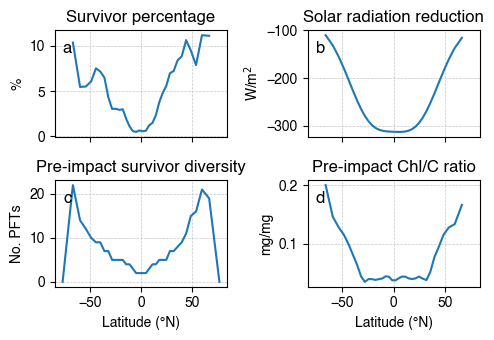

In [4]:
fig, axes = plt.subplots(2,2, figsize=(5,3.5), sharex=True, tight_layout=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

axs = axes.flatten()

extinction_rate = total_effect[-1]/total_effect[0] * 100

## apply the new mask
extinction_rate = mask_arctic(extinction_rate)
light_diff = mask_arctic(light_diff)

axs[0].plot(extinction_rate.lat, extinction_rate.mean(dim='lon'))
axs[1].plot(light_diff.lat, light_diff.mean(dim='lon'))
richness.plot(ax=axs[2])
#axs[3].plot(chl_c.data.lat, chl_c.mean(dim='lon'))
chl_c.plot(ax=axs[3])

axs[0].set_title('Survivor percentage')
axs[1].set_title('Solar radiation reduction')
axs[2].set_title("Pre-impact survivor diversity")
axs[3].set_title('Pre-impact Chl/C ratio')

labels = ['a', 'b', 'c','d']

axs[0].set_ylabel('%')
axs[1].set_ylabel('W/m$^2$')
axs[2].set_ylabel('No. PFTs')
axs[3].set_ylabel('mg/mg')

for i, ax in enumerate(axs):
    ax.text(0.1, .9, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


axs[2].set_xlabel('Latitude (°N)')
axs[3].set_xlabel('Latitude (°N)')

fig.savefig('../output/pico_frac.png', dpi=300, bbox_inches='tight')